In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Colab will still use GPU when available
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Load and sample 100K for dev (adjustable)
df = pd.read_csv('/content/readmission_features.csv').sample(n=100_000, random_state=42)
df = df.drop(columns=["subject_id", "hadm_id"])
df['admission_risk'] = df['icu_stay'] * df['prev_admissions']
df['glucose_sodium_ratio'] = df['mean_glucose'] / (df['mean_sodium'] + 1e-5)
df['renal_index'] = df['mean_creatinine'] * df['comorbidity_index']
df['hba1c_risk'] = df['mean_hba1c'] * df['mean_glucose']

y = df['readmission_30d']
X = df.drop(columns=['readmission_30d'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCELoss(reduction='none')
    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        pt = torch.where(targets == 1, inputs, 1 - inputs)
        loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return loss.mean()

# Residual TabTransformer - Deeper MLP
class AttentionTabTransformer(nn.Module):
    def __init__(self, num_features, emb_dim=64, n_heads=4, ff_dim=256, dropout=0.2):
        super(AttentionTabTransformer, self).__init__()
        self.feature_embed = nn.Linear(1, emb_dim)
        self.feature_pos_embed = nn.Parameter(torch.randn(num_features, emb_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=n_heads, dim_feedforward=ff_dim,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=4)

        self.residual = nn.Sequential(
            nn.Linear(emb_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Dropout(dropout),
            nn.Linear(128, emb_dim)
        )

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = x.to(self.feature_pos_embed.device)
        x = x.unsqueeze(-1)
        x = self.feature_embed(x)
        x = x + self.feature_pos_embed.unsqueeze(0)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.residual(x) + x
        return torch.sigmoid(self.mlp(x))


In [ ]:

from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cpu")

model = AttentionTabTransformer(num_features=X_train.shape[1]).to(device)
criterion = FocalLoss()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=256, shuffle=False)

import torch.optim as optim
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
best_val_loss = float('inf'); patience = 10; early_stop_counter = 0

for epoch in range(15):
    model.train()
    train_loss, y_train_pred, y_train_true = 0, [], []

    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        y_train_pred += (preds > 0.5).int().tolist()
        y_train_true += yb.int().tolist()

    train_loss_avg = train_loss / len(train_loader)
    train_acc = accuracy_score(y_train_true, y_train_pred)

    model.eval()
    val_loss, y_val_pred, y_val_true = 0, [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb).squeeze()
            loss = criterion(preds, yb)
            val_loss += loss.item()
            y_val_pred += (preds > 0.5).int().tolist()
            y_val_true += yb.int().tolist()

    val_loss_avg = val_loss / len(test_loader)
    val_acc = accuracy_score(y_val_true, y_val_pred)

    train_losses.append(train_loss_avg)
    val_losses.append(val_loss_avg)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss_avg:.4f}, Val Loss={val_loss_avg:.4f}, "
          f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    scheduler.step(val_loss_avg)

    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


Epoch 1: Train Loss=0.0319, Val Loss=0.0312, Train Acc=0.7975, Val Acc=0.8013
Epoch 2: Train Loss=0.0313, Val Loss=0.0307, Train Acc=0.7983, Val Acc=0.8013
Epoch 3: Train Loss=0.0312, Val Loss=0.0307, Train Acc=0.7985, Val Acc=0.8004
Epoch 4: Train Loss=0.0312, Val Loss=0.0308, Train Acc=0.7990, Val Acc=0.8028
Epoch 5: Train Loss=0.0311, Val Loss=0.0307, Train Acc=0.7988, Val Acc=0.8032
Epoch 6: Train Loss=0.0311, Val Loss=0.0307, Train Acc=0.7992, Val Acc=0.8013
Epoch 7: Train Loss=0.0311, Val Loss=0.0307, Train Acc=0.7994, Val Acc=0.8013
Epoch 8: Train Loss=0.0311, Val Loss=0.0307, Train Acc=0.7991, Val Acc=0.8013
Epoch 9: Train Loss=0.0310, Val Loss=0.0305, Train Acc=0.7995, Val Acc=0.8030
Epoch 10: Train Loss=0.0310, Val Loss=0.0306, Train Acc=0.7996, Val Acc=0.8032
Epoch 11: Train Loss=0.0309, Val Loss=0.0306, Train Acc=0.7996, Val Acc=0.8034
Epoch 12: Train Loss=0.0310, Val Loss=0.0306, Train Acc=0.8002, Val Acc=0.8020
Epoch 13: Train Loss=0.0309, Val Loss=0.0307, Train Acc=0.799

 Final Accuracy: 0.8035

 Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89     16026
           1       0.62      0.03      0.06      3974

    accuracy                           0.80     20000
   macro avg       0.71      0.51      0.47     20000
weighted avg       0.77      0.80      0.72     20000



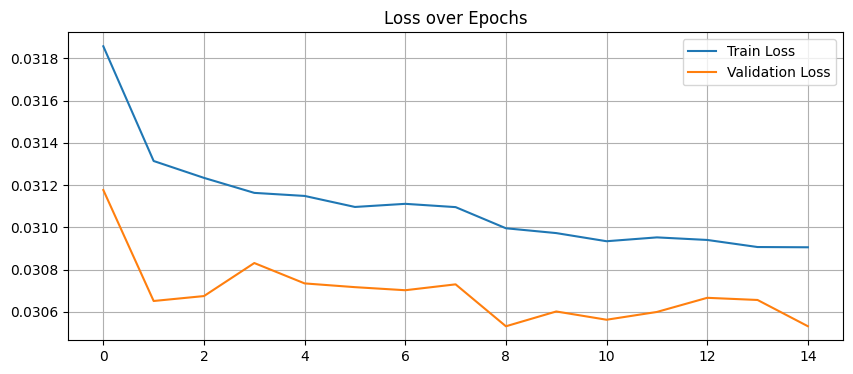

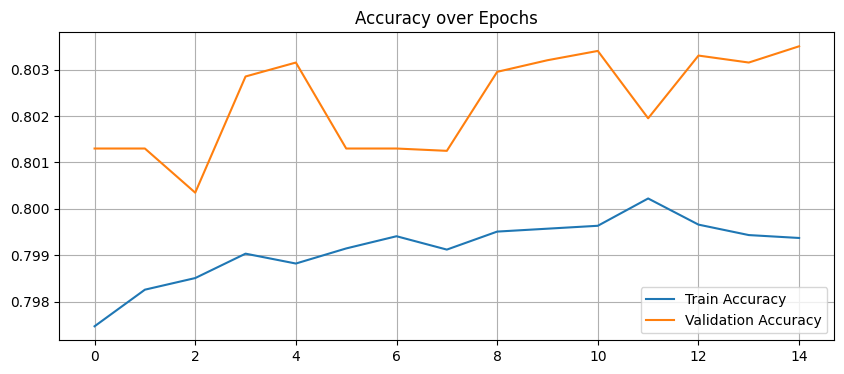

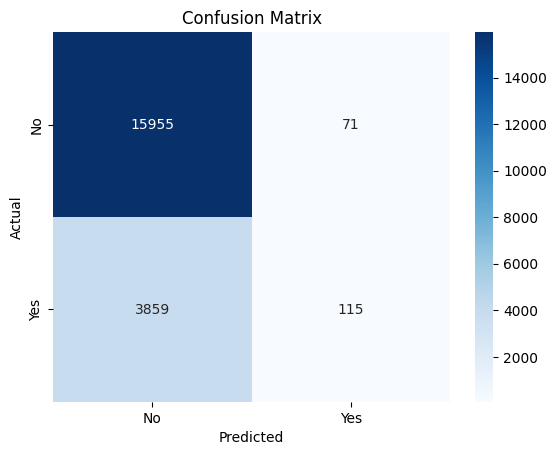

In [ ]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).squeeze().numpy()
    y_pred_class = (y_pred_prob > 0.5).astype(int)

print(f" Final Accuracy: {accuracy_score(y_test, y_pred_class):.4f}")
print("\n Classification Report:\n", classification_report(y_test, y_pred_class))

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend(); plt.grid(); plt.title("Loss over Epochs"); plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.legend(); plt.grid(); plt.title("Accuracy over Epochs"); plt.show()

cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


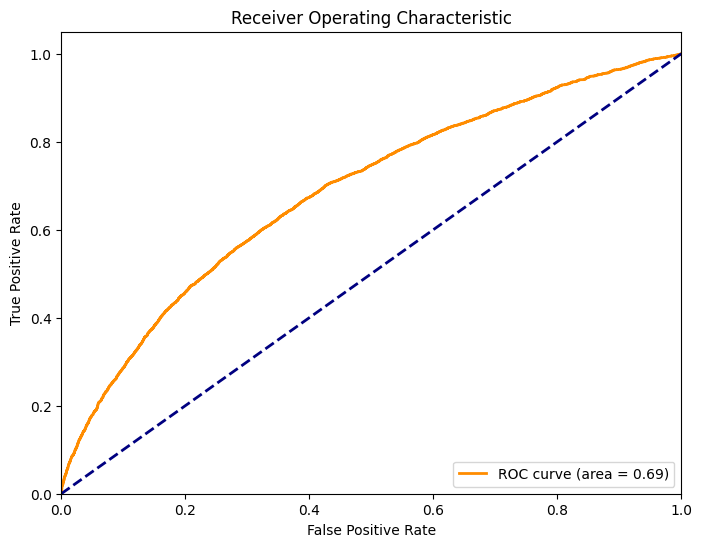

In [ ]:
# prompt: generate auroc curve

from sklearn.metrics import roc_curve, auc

# ... (Your existing code) ...

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# After training your model:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).squeeze().cpu().numpy()
    y_true = y_test_tensor.cpu().numpy()

# Apply partitioned hill climbing
opt_preds, opt_score = partitioned_hill_climb(y_pred_prob, y_true, metric='accuracy', max_iter=100)

print("✅ Optimized Accuracy:", accuracy_score(y_true, opt_preds))
print("📊 Optimized F1 Score:", f1_score(y_true, opt_preds))

✅ Optimized Accuracy: 0.8025
📊 Optimized F1 Score: 0.01200600300150075
